In [1]:
# Import python packages
import pandas as pd
import numpy as np
import calendar

In [2]:
# Generate a list of file names matching the Census microdata files
latest_month = '7/1/2018'
cps_files = [f'{calendar.month_abbr[m.month].lower()}{m.year % 100}pub.dat' 
               for m in pd.date_range(end=latest_month, periods=24, freq='MS')]

In [3]:
# Microdata files are fixed-width
# The variable locations are from the data dictionary
cps_vars = [('GTCBSA', 95, 100),     # CBSA (geo area)
            ('PRTAGE', 121, 123),    # Person's age
            ('PEMLR', 179, 181),     # Person's labor market status
            ('PWCMPWGT', 845, 855)]  # Person's composite weight

path = 'E:/08_Other/Archive/data'  # Location of microdata files

In [4]:
d = {} # Empty dictionary to store monthly files
for file in cps_files:
    d[file] = (pd.read_fwf(f'{path}/{file}', 
                          colspecs=[[v[1], v[2]] for v in cps_vars],
                          names=[v[0] for v in cps_vars])
               .query('PEMLR != -1 and PWCMPWGT > 0 and GTCBSA > 0 '
                      'and PRTAGE > 15 and PRTAGE < 65'))

df = pd.concat(d, ignore_index=True)     # Combine into one dataframe

In [5]:
# Check sample size to make sure I have at least 500 observations
min_obs = df.groupby('GTCBSA')['PEMLR'].agg('count').min()
max_obs = df.groupby('GTCBSA')['PEMLR'].agg('count').max()

print(f'Between {min_obs} and {max_obs} observations per CBSA')

Between 535 and 81063 observations per CBSA


In [6]:
df.groupby('GTCBSA')['PEMLR'].agg('count').sort_values()

GTCBSA
47220      535
13980      586
16060      656
12020      711
27780      713
36780      730
48140      745
40980      770
14020      775
47580      804
12700      823
35660      859
22500      865
31420      866
27500      893
29200      900
42020      971
48660      976
40220      978
15680      987
34740      992
10180     1006
14010     1008
39820     1018
48700     1022
25940     1024
16540     1029
49020     1040
47380     1045
39140     1052
         ...  
12580    11380
16740    11658
41620    11965
41180    12673
19740    12895
28140    12961
14260    13224
45300    13229
41740    14268
10740    15070
38900    16749
33460    16928
29820    17977
40140    18892
19820    19319
42660    19397
46520    19525
38060    20040
41860    20410
39300    20990
33100    24878
12060    25285
26420    27044
19100    29861
37980    33243
14460    35476
16980    41676
47900    56892
31080    60308
35620    81063
Name: PEMLR, Length: 260, dtype: int64

In [6]:
# Calculate disabled NILF share of age group, by CBSA
dis = lambda x: np.average(np.where(x['PEMLR'] == 6, 1, 0), weights=x['PWCMPWGT'])
dis_list = df.groupby('GTCBSA').apply(dis)
dis_list.index = dis_list.index.map(str)

In [15]:
# Decide where to split the color codes for the map
bins = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.2]
colors = ['#4d9221', '#a1d76a', '#e6f5d0', '#f7f7f7', '#fde0ef', '#e9a3c9', '#c51b7d']
colormap = pd.cut(dis_list, bins, labels=colors).to_dict()

In [12]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [16]:
# Show contiguous US (and move Hawaii, no data for Alaska):
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

<Figure size 432x288 with 0 Axes>

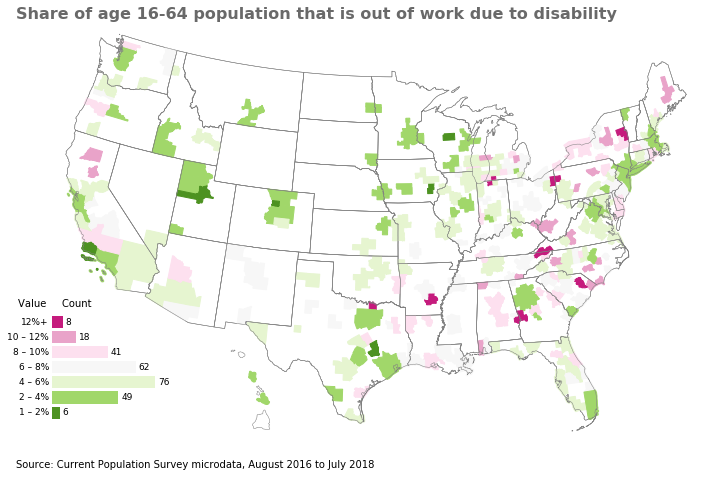

In [20]:
plt.gcf()
plt.figure(figsize=(16,8))

# Read the shapefiles contained in the Shape folder
m.readshapefile('Shape/st99_d00', 'states', drawbounds=True, color='gray')
m.readshapefile('Shape/tl_2013_us_cbsa', 'cbsa', drawbounds=False)
ax = plt.gca()

for info, shape in zip(m.states_info, m.states):
    seg = shape
    if info['NAME'] == 'Hawaii' and float(info['AREA']) > 0.005:
        seg = [[x + 5200000, y-1400000] for x,y in shape]
    ax.add_patch(Polygon(seg, facecolor='white', edgecolor='gray', linewidth=0.5))

for info, shape in zip(m.cbsa_info, m.cbsa):
    if info['GEOID'] in colormap.keys(): 
        color = colormap[info['GEOID']]
        seg = shape
        if info['NAME'][-2:] == 'HI' and info['RINGNUM'] == 1:
            seg = [[x + 5200000, y-1400000] for x,y in shape]
        ax.add_patch(Polygon(seg, facecolor=color, edgecolor=color))   

plt.title('Share of age 16-64 population that is out of work due to disability', 
          fontsize=16, fontweight=800, loc='left', color='dimgrey')
plt.annotate('Source: Current Population Survey microdata, August 2016 to July 2018',
             (0,0), (0, 0), fontsize=10, xycoords='axes fraction',
             textcoords='offset points', va='top')

ax.axis('off')

ax_inset = inset_axes(ax, width="16%", height="26%", loc=3, borderpad=3.6)
bars = list(pd.cut(dis_list, bins).reset_index().groupby(0)['GTCBSA'].nunique().values)
labels = [f'{int(x.left*100)} – {int(x.right*100)}%' 
          for x in pd.cut(dis_list, bins).sort_values().unique()[:-1]]
labels.append('12%+')
ax_inset.barh(list(range(0, len(bars))), bars, align='center', color=colors)
ax_inset.axis('off')
for i, bar in enumerate(bars):
    ax_inset.text(bar+2, i, bar, fontsize=9, va='center')
for i, label in enumerate(labels):
    ax_inset.text(-2, i, label, fontsize=9, va='center', ha='right')
ax_inset.text(-25, 7, 'Value     Count')

plt.savefig('dis_map.svg', bbox_inches='tight', dpi=500)
plt.show()

In [14]:
cbsas = {c['GEOID']: c['NAME'] for c in m.cbsa_info}
for cbsa, val in dis_list.sort_values().iteritems():
    print(f'{cbsas[str(cbsa)]}: {round(val * 100, 1)}%')

Iowa City, IA: 1.6%
Provo-Orem, UT: 1.6%
College Station-Bryan, TX: 1.6%
Wausau, WI: 1.7%
Boulder, CO: 1.9%
Santa Maria-Santa Barbara, CA: 1.9%
Springfield, IL: 2.1%
Madison, WI: 2.1%
Bridgeport-Stamford-Norwalk, CT: 2.2%
Austin-Round Rock, TX: 2.2%
Bend-Redmond, OR: 2.3%
Oshkosh-Neenah, WI: 2.3%
Washington-Arlington-Alexandria, DC-VA-MD-WV: 2.3%
Salt Lake City, UT: 2.5%
Laredo, TX: 2.7%
Hilton Head Island-Bluffton-Beaufort, SC: 2.7%
San Francisco-Oakland-Hayward, CA: 2.9%
Fargo, ND-MN: 2.9%
Minneapolis-St. Paul-Bloomington, MN-WI: 2.9%
Fort Collins, CO: 3.0%
Denver-Aurora-Lakewood, CO: 3.0%
Santa Cruz-Watsonville, CA: 3.1%
San Jose-Sunnyvale-Santa Clara, CA: 3.1%
Appleton, WI: 3.2%
Dallas-Fort Worth-Arlington, TX: 3.2%
Ann Arbor, MI: 3.2%
Burlington-South Burlington, VT: 3.2%
Lexington-Fayette, KY: 3.2%
Lancaster, PA: 3.3%
Urban Honolulu, HI: 3.3%
Miami-Fort Lauderdale-West Palm Beach, FL: 3.4%
Houston-The Woodlands-Sugar Land, TX: 3.4%
Kahului-Wailuku-Lahaina, HI: 3.4%
Gainesville, G

In [ ]:
bars = list(pd.cut(dis_list, bins).reset_index().groupby(0)['GTCBSA'].nunique().values)
labels = [f'{round(x.left*100,0)}-{round(x.right*100,0)}%' for x in pd.cut(dis_list, bins).sort_values().unique()[:-1]]

In [ ]:
bars = pd.Series(colormap).reset_index().groupby(0)['index'].nunique().reset_index()

In [ ]:
list(range(0, len(bars)))

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
bars = list(pd.cut(dis_list, bins).reset_index().groupby(0)['GTCBSA'].nunique().values)
labels = [f'{int(x.left*100)} - {int(x.right*100)}%' for x in pd.cut(dis_list, bins).sort_values().unique()[:-1]]
labels.append('12%+')
plt.gcf()
plt.figure(figsize=(3,3))
plt.barh(list(range(0, len(bars))), bars, align='center', color=colors)
plt.axis('off')
for i, bar in enumerate(bars):
    plt.text(bar+2, i, bar, fontsize=10, verticalalignment='center')
for i, label in enumerate(labels):
    plt.text(-1, i, label, fontsize=9, verticalalignment='center', horizontalalignment='right')

In [ ]:
labels = [f'{round(x.left*100,0)}-{round(x.right*100,0)}%' for x in pd.cut(dis_list, bins).sort_values().unique()[:-1]]

In [ ]:
labels

In [ ]:
labels.append('12%+')

In [ ]:
[[s.left, s.right] for s in pd.cut(dis_list, bins).sort_values().unique()]

In [ ]:
bars.sort_values(by=0)

In [ ]:
bars

In [ ]:
# cbsas = {c['GEOID']: c['NAME'] for c in m.cbsa_info}
# for cbsa, val in dis_list.iteritems():
#     print(f'{cbsas[str(cbsa)]}: {round(val * 100, 1)}%')

# bins = pd.IntervalIndex.from_tuples([(0, 0.02), 
#                                      (0.02, 0.04), 
#                                      (0.04, 0.06), 
#                                      (0.06, 0.08), 
#                                      (0.08, 0.10), 
#                                      (0.10, 0.12), 
#                                      (0.12, 0.2)])

bins = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.2]
colors = ['#4d9221', '#a1d76a', '#e6f5d0', '#f7f7f7', '#fde0ef', '#e9a3c9', '#c51b7d']
colormap = pd.cut(dis_list, bins, labels=colors).to_dict()

In [ ]:
dis_list

In [ ]:
m(3990140.533171402, 2005714.2148839906)

In [ ]:
m.cbsa

In [ ]:
%matplotlib inline
dis_list.hist()

In [ ]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

In [ ]:
# Show full US:
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

In [ ]:
plt.gcf()
fig = plt.figure(figsize=(16,8))

# Read the shapefile contained in the same folder (and the two related files)
m.readshapefile('Shape/st99_d00', 'states', drawbounds=True, color='grey')
m.readshapefile('Shape/tl_2013_us_cbsa', 'cbsa', drawbounds=False, color='grey')
ax = plt.gca()

for shape in m.states_info:
    sh_num = int(shape['SHAPENUM'] - 1)
    if shape['NAME'] == 'Hawaii' and float(shape['AREA']) > 0.005:
        seg = [tuple([x + 5200000, y-1400000]) for x,y in m.states[sh_num]]
    elif shape['NAME'] == 'Alaska' and float(shape['AREA']) > 0.0005:
        seg = [tuple([0.35*x + 1100000, 0.35*y-1300000]) for x,y in m.states[sh_num]]
    poly = Polygon(seg, facecolor='white', edgecolor='gray', linewidth=.5)
    ax.add_patch(poly) 

for info, shape in zip(m.cbsa_info, m.cbsa):
    if info['GEOID'] in list(dis_list[:5].index.astype('str')):
        ax.add_patch(Polygon(shape, facecolor='blue'))    
    
# vlow = []
# for info, shape in zip(m.cbsa_info, m.cbsa):
#     if info['GEOID'] in list(dis_list[:5].index.astype('str')):
#         vlow.append(Polygon(np.array(shape), True))
#     if info ['NAME'][-2:] == 'HI' and info['RINGNUM'] == 1:
#         poly = Polygon(np.array([tuple([x + 5200000, y-1400000]) for x,y in shape]), True)
#         vlow.append(poly)
#     if info ['NAME'][-2:] == 'AK' and info['RINGNUM'] == 1:
#         poly = Polygon(np.array([tuple([0.35*x + 1100000, 0.35*y-1300000]) for x,y in shape]), True)
#         vlow.append(poly)
    
# ax.add_collection(
#     PatchCollection(vlow, facecolor='#4d9221', edgecolor='gray', 
#                     alpha=0.8, zorder=2))

ax.axis('off')
plt.show()

In [ ]:
vlow

In [ ]:
PatchCollection(vlow, facecolor='#4d9221', edgecolor='gray', 
                    alpha=0.8, zorder=2)

In [ ]:
list(dis_list[:5].index.astype('str'))

In [ ]:
m.cbsa_info

In [ ]:
cbsas = {c['GEOID']: c['NAME'] for c in m.cbsa_info}
for cbsa, val in dis_list.iteritems():
    print(f'{cbsas[str(cbsa)]}: {round(val * 100, 1)}%')

In [ ]:
cbsas = {c['GEOID']: c['NAME'] for c in m.cbsa_info}

In [ ]:
list(set([c['GEOID'] for c in m.cbsa_info if c['NAME'][-2:] == 'HI']))

In [ ]:
cbsas = {c['GEOID']: c['NAME'] for c in m.cbsa_info}
for cbsa, val in dis_list.iteritems():
    print(f'{cbsas[str(cbsa)]}: {round(val * 100, 1)}%')

bins = pd.IntervalIndex.from_tuples([(0, 0.02), 
                                     (0.02, 0.04), 
                                     (0.04, 0.06), 
                                     (0.06, 0.08), 
                                     (0.08, 0.10), 
                                     (0.10, 0.12), 
                                     (0.12, 0.2)])

pd.cut(dis_list, bins)

In [ ]:
pd.cut(dis_list, bins)

In [ ]:
dis_list

In [ ]:
m.cbsa

In [ ]:
df = pd.DataFrame()  # Empty dataframe to fill with monthly data
for cps_file in cps_files:
    df = df.append(pd.read_fwf(f'{path}/{cps_file}', 
                      colspecs=[tuple([v[1], v[2]]) for v in cps_vars],
                      names=[v[0] for v in cps_vars])
                   .query('PEMLR != -1 and PWCMPWGT > 0 and GTCBSA > 0 '
                          'and PRTAGE > 15 and PRTAGE < 65'))

In [ ]:
dis = lambda x: np.average(np.where(x['PEMLR'] == 6, 1, 0), weights=x['PWCMPWGT'])
dis_list = df.query('PRTAGE > 15 and PRTAGE < 65').groupby('GTCBSA').apply(dis).sort_values()

In [ ]:
dis_list

In [ ]:
dis = lambda x: np.average(np.where(x['PEMLR'] == 6, 1, 0), weights=x['PWCMPWGT'])
dis_list = df.query('PRTAGE > 24 and PRTAGE < 55').groupby('GTCBSA').apply(dis).sort_values()
#dislist = list((dis2014 * 100)[-80:].index)

In [ ]:
dch = (dis2017 - dis2014).dropna()

In [ ]:
dkgreen = [str(cbsa) for cbsa, value in list(zip(dch.keys(), dch.values)) if value <= -0.05]
mdgreen = [str(cbsa) for cbsa, value in list(zip(dch.keys(), dch.values)) if value <= -0.025 and value > -0.005]
ltgreen = [str(cbsa) for cbsa, value in list(zip(dch.keys(), dch.values)) if value <= -0.005 and value > -0.025]
neutral = [str(cbsa) for cbsa, value in list(zip(dch.keys(), dch.values)) if value < 0.005 and value >= -0.005]
ltpink = [str(cbsa) for cbsa, value in list(zip(dch.keys(), dch.values)) if value < 0.025 and value >= 0.005]
mdpink = [str(cbsa) for cbsa, value in list(zip(dch.keys(), dch.values)) if value < 0.05 and value >= 0.025]
dkpink = [str(cbsa) for cbsa, value in list(zip(dch.keys(), dch.values)) if value >= 0.05]

In [ ]:
blist = [str(i) for i in (dis2016 - dis2014).dropna().sort_values()[0:20].index]

# Map

In [ ]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

In [ ]:
# Show full US:
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

In [ ]:
plt.gcf()
fig = plt.figure(figsize=(16,8))

# Read the shapefile contained in the same folder (and the two related files)
m.readshapefile('Shape/st99_d00', 'states', drawbounds=True, color='grey')
m.readshapefile('Shape/tl_2013_us_cbsa', 'cbsa', drawbounds=False, color='grey')
ax = plt.gca()

for shape in m.states_info:
    sh_num = int(shape['SHAPENUM'] - 1)
    if shape['NAME'] == 'Hawaii' and float(shape['AREA']) > 0.005:
        seg = [tuple([x + 5200000, y-1400000]) for x,y in m.states[sh_num]]
    elif shape['NAME'] == 'Alaska' and float(shape['AREA']) > 0.0005:
        seg = [tuple([0.35*x + 1100000, 0.35*y-1300000]) for x,y in m.states[sh_num]]
    poly = Polygon(seg, facecolor='white', edgecolor='gray', linewidth=.5)
    ax.add_patch(poly)

vlow, mlow, llow, neu, lhi, mhi, vhi = ([] for i in range(7))
for info, shape in zip(m.cbsa_info, m.cbsa):
    if info['GEOID'] in dkgreen:
        vlow.append(Polygon(np.array(shape), True))
    if info['GEOID'] in mdgreen:
        mlow.append(Polygon(np.array(shape), True))
    if info['GEOID'] in ltgreen:
        llow.append(Polygon(np.array(shape), True))
    if info['GEOID'] in neutral:
        neu.append(Polygon(np.array(shape), True))
    if info['GEOID'] in ltpink:
        lhi.append(Polygon(np.array(shape), True))
    if info['GEOID'] in mdpink:
        mhi.append(Polygon(np.array(shape), True))
    if info['GEOID'] in dkpink:
        vhi.append(Polygon(np.array(shape), True))

ax.add_collection(
    PatchCollection(vlow, facecolor='#4d9221', edgecolor='gray', 
                    alpha=0.8, zorder=2))
ax.add_collection(
    PatchCollection(mlow, facecolor='#a1d76a', edgecolor='gray', 
                    alpha=0.8, zorder=2))
ax.add_collection(
    PatchCollection(llow, facecolor='#fde0ef', edgecolor='gray', 
                    alpha=0.8, zorder=2))
ax.add_collection(
    PatchCollection(neu, facecolor='#f7f7f7', edgecolor='gray', 
                    alpha=0.8, zorder=2))
ax.add_collection(
    PatchCollection(lhi, facecolor='#e6f5d0', edgecolor='gray', 
                    alpha=0.8, zorder=2))
ax.add_collection(
    PatchCollection(mhi, facecolor='#a1d76a', edgecolor='gray', 
                    alpha=0.8, zorder=2))
ax.add_collection(
    PatchCollection(vhi, facecolor='#c51b7d', edgecolor='gray', 
                    alpha=0.8, zorder=2))
    
ax.axis('off')
plt.show()

In [ ]:
for shape in m.states_info:
    sh_num = int(shape['SHAPENUM'] - 1)
    if shape['NAME'] == 'Hawaii' and float(shape['AREA']) > 0.005:
        seg = [tuple([x + 5200000, y-1400000]) for x,y in m.states[sh_num]]
    elif shapedict['NAME'] == 'Alaska':
        seg = [tuple([0.35*x + 1100000, 0.35*y-1300000]) for x,y in m.states[sh_num]]
    poly = Polygon(seg, facecolor='white', edgecolor='gray', linewidth=.5)
    ax.add_patch(poly)
        #    seg = list(map(lambda (x,y): (x + 5200000, y-1400000), seg))

In [ ]:
list(set([v['GEOID'] for v in m.cbsa_info if v['NAME'][-2:] == 'HI']))

In [ ]:
m.cbsa_info[0]['NAME'][-2:]

In [ ]:
patches = []

for info, shape in zip(m.cbsa_info, m.cbsa):
    if info['GEOID'] == '40380':
        patches.append(Polygon(np.array(shape), True))
        
ax.add_collection(PatchCollection(patches, facecolor='blue', edgecolor='darkgray', alpha=0.8, linewidths=1., zorder=2))

In [ ]:
list(map(lambda (x,y): (x + 5200000, y-1400000), seg))

In [ ]:
[tuple([x + 5200000, y-1400000]) for x,y in m.states[sh_num]]

In [ ]:
# Thanks to stackexchange for this solution to include Alaska and Hawaii
for i, shapedict in enumerate(m.states_info):
    # Translate the noncontiguous states:
    if shapedict['NAME'] in ['Alaska', 'Hawaii']:
        seg = m.states[int(shapedict['SHAPENUM'] - 1)]
        # Only include the 8 main islands of Hawaii 
        if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > 0.005:
            seg = list(map(lambda (x,y): (x + 5200000, y-1400000), seg))
        # Alaska is large. Rescale it.
        elif shapedict['NAME'] == 'Alaska':
            seg = list(map(lambda (x,y): (0.35*x + 1100000, 0.35*y-1300000), seg))
        poly = Polygon(seg, facecolor='white', edgecolor='gray', linewidth=.5)
        ax.add_patch(poly)


In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import numpy as np

plt.gcf()
fig = plt.figure(figsize=(16,12))

# Read the shapefile contained in the same folder (and the two related files)
m.readshapefile('st99_d00', 'states', drawbounds=True, color='grey')
m.readshapefile('roadtrl020', 'roads', drawbounds=False)
m.readshapefile('cb_2016_us_csa_500k', 'msa', drawbounds=False, color='grey')
#m.drawlsmask(land_color='#F2F3F4',ocean_color='white', resolution='i')
m.fillcontinents(color='#F2F3F4')
ax = plt.gca()

for info, shape in zip(m.roads_info, m.roads):
    if 'Highway' in info['FEATURE']:
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='lightgray')

patches   = []

for info, shape in zip(m.msa_info, m.msa):
    if info['NAME'] == 'Washington-Baltimore-Arlington, DC-MD-VA-WV-PA':
        patches.append( Polygon(np.array(shape), True) )
        
ax.add_collection(PatchCollection(patches, facecolor= 'blue', edgecolor='k', alpha=0.1, linewidths=1., zorder=2))

# Plot each location, value, and color as identified in the previous section        
for index, row in unemp_list.iterrows():
    m.plot(row['x'], row['y'], marker='o', color=row['color'], alpha=0.5, 
           markersize = row['size'], markeredgecolor='Black', markeredgewidth=.25)

ax.axis('off')    # Remove default border
plt.title('One-year Change in Unemployment Rate, as of ' + date)
plt.annotate('Data Source: U.S. Bureau of Labor Statistics, Local Area Unemployment Statistics; \n' \
             'Code: https://github.com/bdecon/Python/tree/master/Unemp_Map',
             (0,0), (0, 0), fontsize=9, xycoords='axes fraction', textcoords='offset points', va='top')

# Legend 
l1 = plt.scatter([],[], marker='o',color='Limegreen', alpha=0.5, 
              s = 130, edgecolors='Black', linewidth=.25)
l2 = plt.scatter([],[], marker='o',color='Red', alpha=0.5, 
              s = 130, edgecolors='Black', linewidth=.25)

labels = ["$-$1%", "+1%"]

leg = plt.legend([l1, l2], labels, ncol=1, frameon=False, fontsize=10,
    handlelength=2, loc = 2, borderpad = 1.8,
    handletextpad=1, title='Legend', scatterpoints = 1)
plt.savefig('C:\Users\BDew\Dropbox (CEPR)\homestata\Brian\For_Alan\State_Labor\Graphics\unemp_map.pdf', bbox_inches='tight', dpi=500)
plt.show()